In [1]:
# Import packages
import datetime
import geopandas as gpd
import holidays
# import july
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from dbfread import DBF
# import seaborn as sns
import shutil
import time
# Import CEA modules
import cea.config
import cea.api 
from cea.utilities.dbf import *
from cea.utilities.epwreader import epw_reader
from cea.datamanagement.archetypes_mapper import archetypes_mapper
from cea.datamanagement.archetypes_mapper import main as archetypes_mapper_main
from cea.demand.schedule_maker.schedule_maker import main as schedule_maker
from cea.demand.demand_main import main as demand_main
from cea.resources.radiation.main import main as radiation_main

#Take default dependencies for DAYSIM
# DAYSIM_BIN_DIRECTORY = os.path.join(os.getcwd(), 'CEA_model', '0_daysim_binaries')
project_folder = os.path.join(os.getcwd(), 'CEA_model337')


zone_gdf = gpd.read_file(
    os.path.join(project_folder, 'Baseline', '2020', 'inputs', 'building-geometry', 'zone.shp')) 
list_buildings = zone_gdf["Name"].tolist() 

selection_gdf = zone_gdf.copy()
selection_gdf


,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,postcode,house_name,resi_type,city,country,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384874.043 5820594.084, 384873.807 5..."
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,10589,NaN,NaN,Berlin,DE,"POLYGON ((385147.715 5821181.978, 385145.006 5..."
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385315.603 5820595.263, 385265.770 5..."
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385231.453 5820685.213, 385230.993 5..."
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385092.809 5820650.440, 385096.097 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,1.0,1,3.0,1,NaN,yes,OSM - as it is,17-20,Tegeler Weg,10589,NaN,NaN,Berlin,DE,"POLYGON ((384583.564 5821007.335, 384573.938 5..."
787,B1787,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384534.446 5821185.198, 384551.996 5..."
788,B1788,6.0,6,3.0,1,NaN,apartments,OSM - as it is,21,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384788.185 5820672.254, 384786.705 5..."
789,B1789,6.0,6,3.0,1,NaN,apartments,OSM - as it is,23,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384799.372 5820694.503, 384795.628 5..."


In [2]:
# drop everything that is smaller than 40m2  
selection_gdf["area"] = selection_gdf["geometry"].area
buildings_above_40sqm = selection_gdf.query('area> 40')["Name"]

In [3]:
# adjust type on main type for block 
# first check if there is an overlap 
import os 
dir_path = os.getcwd()
shape_data_path = os.path.join(dir_path, 'auxillary',  '00_block_shape.shp')
shapes = gpd.read_file(shape_data_path)
shapes["blknr"] = shapes["blknr"].astype('int64') 
file_path_age = os.path.join(dir_path, 'auxillary','02_Gebäudealter.csv') 
age_df = pd.read_csv(file_path_age)
bldg_age_shapes =  shapes.merge(age_df, on='blknr') 

In [4]:
zone_gdf["geometry"].intersects(bldg_age_shapes["geometry"], align=True)



0      False
1      False
2      False
3      False
4      False
       ...  
786    False
787    False
788    False
789    False
790    False
Length: 791, dtype: bool

In [5]:
list(zone_gdf["category"].value_counts().index)

['yes',
 'apartments',
 'residential',
 'industrial',
 'roof',
 'commercial',
 'allotment_house',
 'office',
 'silo',
 'school',
 'hut',
 'public',
 'retail',
 'service',
 'warehouse',
 'garages',
 'church',
 'construction',
 'garage',
 'house',
 'detached',
 'manufacture',
 'kindergarten',
 'electricity',
 'toilets',
 'sports_hall',
 'houseboat']

# Archetye mapping

Drop houseboat, detached, shed, train_station, toilets, bridge, construction, garage (s), hut, allotment_house, bungalow, church (?), roof, silo, electricity

Assume yes is apparment. 

Compare with: https://wiki.openstreetmap.org/wiki/Key:building 

In [6]:
bldg_to_drop = ["houseboat", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house",  "roof", "silo", "electricity"]

In [7]:
bldg_type_list = [x for x in list(zone_gdf["category"].value_counts().index) if x not in bldg_to_drop]
bldg_type_list

['yes',
 'apartments',
 'residential',
 'industrial',
 'commercial',
 'office',
 'school',
 'public',
 'retail',
 'service',
 'warehouse',
 'church',
 'house',
 'manufacture',
 'kindergarten',
 'sports_hall']

In [8]:
ARCHETYPES = {
     "apartments": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "residential": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
      "yes": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "industrial": {
        "1860-1978": "NWG_G2_A",
        "1979-2009": "NWG_G2_B",
        "2010-2030": "NWG_G2_C",
    }, 

    "office": {
        "1860-1978": "NWG_1_A",
        "1979-2009": "NWG_1_B",
        "2010-2030": "NWG_1_C",
    },
      "commercial": {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "retail" : {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "warehouse": {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
        "service" : {
             "1860-1978": "NWG_10_A",
        "1979-2009": "NWG_10_B",
        "2010-2030": "NWG_10_C",
        },
        "school": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    },
    "public": {
           "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }, 
    "house": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },"manufacture" : {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
    
        "kindergarten": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    }, 
    "sports_hall": {
        "1860-1978": "NWG_6_A",
        "1979-2009": "NWG_6_B",
        "2010-2030": "NWG_6_C",
    }
    , 
    "church": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }}



In [9]:
print(ARCHETYPES.keys())

dict_keys(['apartments', 'residential', 'yes', 'industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public', 'house', 'manufacture', 'kindergarten', 'sports_hall', 'church'])


In [10]:
gpd.overlay(zone_gdf, bldg_age_shapes, how='intersection')

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384873.807 5820581.426, 384886.006 5..."
1,B1024,1.0,1,3.0,1,NaN,sports_hall,OSM - as it is,29,Sömmeringstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385043.932 5820642.061, 385043.749 5..."
2,B1026,4.0,4,3.0,1,NaN,public,OSM - as it is,30,Mierendorffstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384922.724 5820735.592, 384929.001 5..."
3,B1114,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385030.143 5820713.906, 385029.951 5..."
4,B1122,3.0,3,3.0,1,NaN,yes,OSM - as it is,22,Nordhauser Straße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384966.057 5820720.330, 384966.311 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,B1779,6.0,6,3.0,1,NaN,residential,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,300.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((385451.043 5820715.937, 385446.869 5..."
1387,B1780,5.0,5,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,323.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384649.990 5821130.060, 384649.766 5..."
1388,B1781,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384620.571 5821059.758, 384631.713 5..."
1389,B1782,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384622.619 5821008.006, 384622.870 5..."


In [11]:
def merge_with_max_overlap(gdf_buildings, gdf_blocks):
    # Initialize an empty list to store the result data
    results = []

    # Iterate over each polygon in gdf_buildings
    for index_a, row_a in gdf_buildings.iterrows():
        max_overlap = 0
        best_match = None

        # Compute intersection with each polygon in gdf_blocks and find the max overlap
        for index_b, row_b in gdf_blocks.iterrows():
            intersection = row_a['geometry'].intersection(row_b['geometry'])
            overlap_area = intersection.area

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_match = row_b

        # Create a new record for the resulting GeoDataFrame
        if best_match is not None:
            merged_attrs = {**row_a.to_dict(), **best_match.to_dict(), 'overlap_area': max_overlap}
            results.append(merged_attrs)

    # Convert the list of dicts to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=zone_gdf.crs)

    return result_gdf


overlap = merge_with_max_overlap(zone_gdf, bldg_age_shapes)

overlap.head()

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,5.0,NaN,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618


In [12]:
# Add data for buildings ['B1325', 'B1769'] to the overlap file, then reorder by name 
selected_buildings = zone_gdf[zone_gdf["Name"].isin(['B1325', 'B1769'])]
overlap= gpd.GeoDataFrame(pd.concat([overlap, selected_buildings], ignore_index=True))

overlap = overlap.sort_values(by='Name')


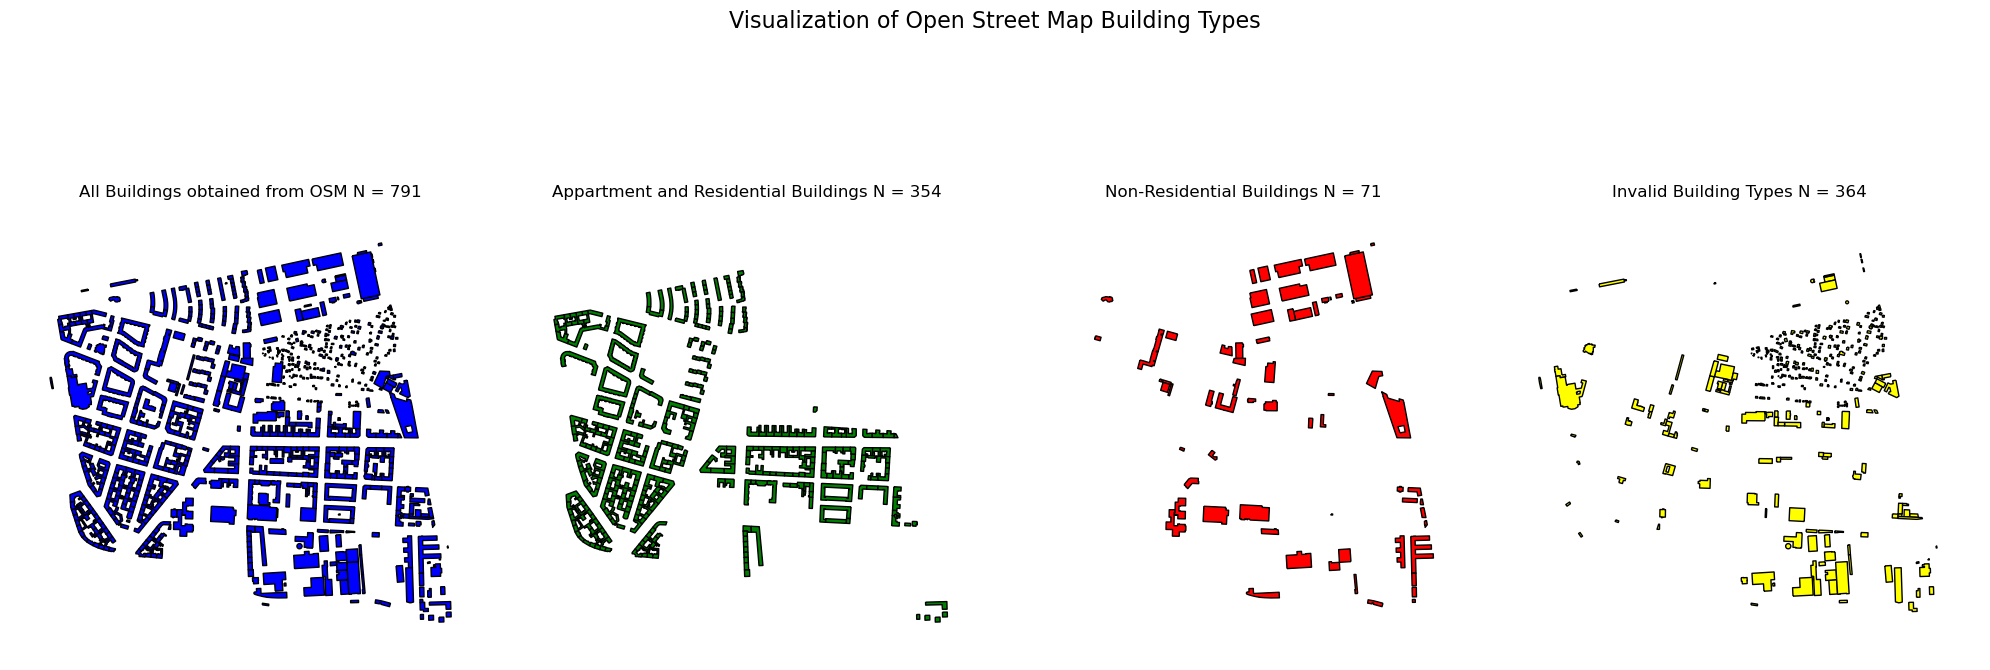

In [13]:
gdf = zone_gdf
# Calculate bounds for consistent axis limits
xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of all geometries

# Extend the bounds a bit for better visualization
xrange = xmax - xmin
yrange = ymax - ymin
xmin -= 0.1 * xrange
xmax += 0.1 * xrange
ymin -= 0.1 * yrange
ymax += 0.1 * yrange

# Plot setup
fig, axs = plt.subplots(1, 4, figsize=(20, 8))  # Horizontal layout with 3 plots

# Plot all geometries
count_all = gdf.shape[0]
gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title(f'All Buildings obtained from OSM N = {count_all}')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)

# Plot residential builings
count_type_residential = gdf[gdf['category'].isin(["residential", "apartments", 'house, "bungalow", '])].shape[0]
gdf[gdf['category'].isin(["residential", "apartments", 'house'])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title(f'Appartment and Residential Buildings N = {count_type_residential}')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)

# Plot non Residential Buildings
# Count type B entries
count_type_non_residential = gdf[gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall', "church",])].shape[0]
gdf[gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall'])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title(f'Non-Residential Buildings N = {count_type_non_residential}')
axs[2].set_xlim(xmin, xmax)
axs[2].set_ylim(ymin, ymax)

# Plot non valid Building Types
count_type_invalid = gdf[gdf['category'].isin(["houseboat", "yes", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house", "roof", "silo", "electricity"])].shape[0]
gdf[gdf['category'].isin(["houseboat", "yes", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house", "bungalow", "church", "roof", "silo", "electricity"])].plot(ax=axs[3], color='yellow', edgecolor='k')
axs[3].set_title(f'Invalid Building Types N = {count_type_invalid}')
axs[3].set_xlim(xmin, xmax)
axs[3].set_ylim(ymin, ymax)

# Remove the axis for a cleaner look and adjust for space between plots
for ax in axs:
    ax.axis('off')

# Common header
plt.suptitle('Visualization of Open Street Map Building Types', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

In [14]:
def merge_with_max_overlap(gdf_buildings, gdf_blocks):
    # Initialize an empty list to store the result data
    results = []

    # Iterate over each polygon in gdf_buildings
    for index_a, row_a in gdf_buildings.iterrows():
        max_overlap = 0
        best_match = None
        best_match_attrs = None

        # Compute intersection with each polygon in gdf_blocks and find the max overlap
        for index_b, row_b in gdf_blocks.iterrows():
            intersection = row_a['geometry'].intersection(row_b['geometry'])
            overlap_area = intersection.area

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_match = row_b
                # Exclude geometry from row_b to preserve the geometry from row_a
                best_match_attrs = {k: v for k, v in row_b.items() if k != 'geometry'}

        # Create a new record for the resulting GeoDataFrame, preserving row_a's geometry
        if best_match is not None:
            merged_attrs = {**row_a.to_dict(), **best_match_attrs, 'overlap_area': max_overlap}
            results.append(merged_attrs)

    # Convert the list of dicts to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=gdf_buildings.crs)  # Ensure the CRS is taken from gdf_buildings

    return result_gdf

# Example usage:
# Assuming zone_gdf and bldg_age_shapes are your GeoDataFrames loaded beforehand
overlap_reduced = merge_with_max_overlap(zone_gdf, bldg_age_shapes)

# Print the first few rows of the resulting GeoDataFrame
overlap_reduced.head()

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,5.0,NaN,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618


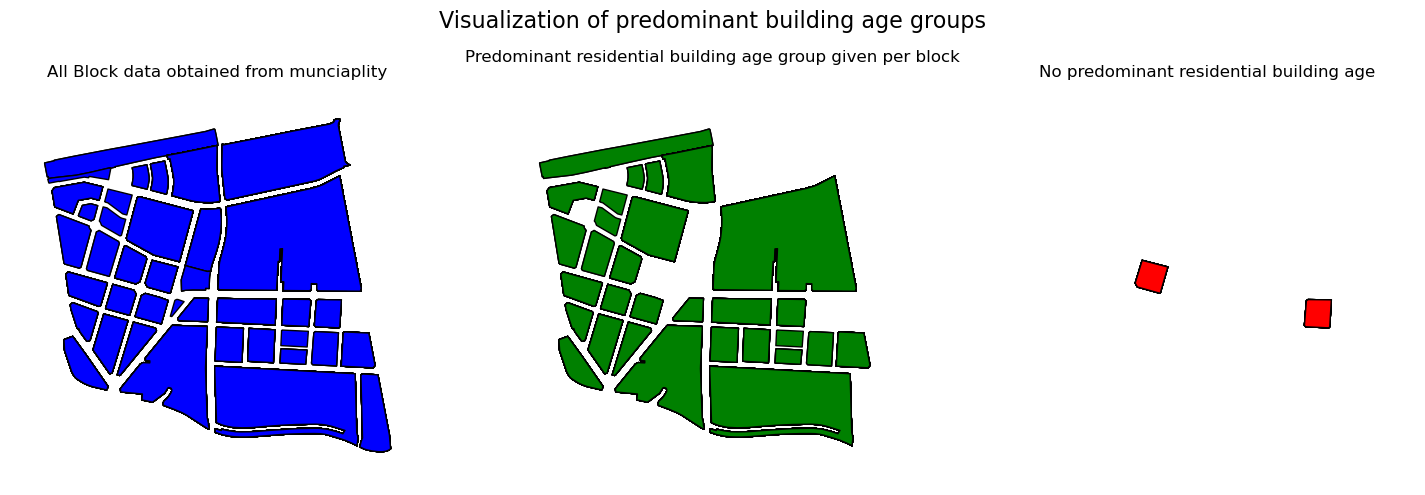

In [15]:

# Ingore yes here, due to diversity of building types
gdf = overlap.copy()
# Calculate bounds for consistent axis limits
xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of all geometries

# Extend the bounds a bit for better visualization
xrange = xmax - xmin
yrange = ymax - ymin
xmin -= 0.1 * xrange
xmax += 0.1 * xrange
ymin -= 0.1 * yrange
ymax += 0.1 * yrange

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Horizontal layout with 3 plots

# Plot all geometries
gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title('All Block data obtained from munciaplity')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)

# Plot types A and C
gdf[gdf['ueberw_dek'].isin(['2001-2010', '1901-1910', '1951-1960', '2011-2015', 'bis 1900', '1921-1930', '1981-1990', '1931-1940'])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title('Predominant residential building age group given per block')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)

# Plot type B
gdf[gdf['ueberw_dek'].isin(["gemischte Baualtersklasse"])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title('No predominant residential building age')
axs[2].set_xlim(xmin, xmax)
axs[2].set_ylim(ymin, ymax)

# Remove the axis for a cleaner look and adjust for space between plots
for ax in axs:
    ax.axis('off')

# Common header
plt.suptitle('Visualization of predominant building age groups', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

In [16]:
def average_year_from_range(year_range):
    # This function extracts the start and end years from a range, calculates the average, and returns it as an integer
    # "gemischte"
    print(year_range, type(year_range))
    if '-' in year_range:
        start_year, end_year = year_range.split('-')
        average_year = (int(start_year) + int(end_year)) // 2
        return average_year
    elif year_range == "gemischte Baualtersklasse":
        return None 
    elif year_range == "bis 1900": 
        return 1900
    elif year_range == "NaN":
        return None 

    return int(year_range)  # Handles cases where the year is not a range but a single year


def find_year_range(bldg_type, year):
    # function determines the year range that a given year falls into based on its categorization  
    if bldg_type in ["yes", "apartments", "residential", "house"] and isinstance(year, int):
        #determine bldg age groups on years
        if 1860 <= year <= 1918:
            return "1860-1918"
        elif 1919 <= year <= 1948:
            return "1919-1948"
        elif 1949 <= year <= 1957:
            return "1949-1957"
        elif 1958 <= year <= 1968:
            return "1958-1968"
        elif 1969 <= year <= 1978:
            return "1969-1978"
        elif 1979 <= year <= 2009:
            return None
        else:
            return None 
    else:
        if isinstance(year, int):
            # Non Residential building groups
            if 1860 <= year <= 1978:
                return "1860-1978"
            elif 1979 <= year <= 2009:
                return "1979-2009"
            elif 2010 <= year <= 2030:
                return "2010-2030"
            else:
                return None
        else:
            return None

def match_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        return None 
    year_range = find_year_range(bldg_type, average_year)
    if bldg_type in ARCHETYPES and year_range in ARCHETYPES[bldg_type]:
        return ARCHETYPES[bldg_type][year_range]
    return None


overlap["ARCHETYPE"] = overlap.apply(lambda row: match_building_type(row['category'], row['ueberw_dek']), axis=1)

1901-1910 <class 'str'>
2001-2010 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1981-1990 <class 'str'>
1981-1990 <class 'str'>
1981-1990 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
nan <class 'float'>
1921-1930 <class 'str'>
2001-2010 <class 'str'>
2001-2010 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
1921-1930 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1931-1940 <class 'str'>
1931-1940 <class 'str'>
1931-1940 <class 'str'>
1951-1960 <class 'str'>
1901-1910 <class 'str'>
nan <class 'float'>
1901-1910 <class 'str'>
2001-2010 <class 'str'>
2001-2010 <class 'str'>
nan <class 'float'>
1901-1910 <class 'str'>
1901-1910 <class 'str'>
2011-2015 <class 'str'>
2011-2015 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
1951-1960 <class 'str'>
gemischte Baualtersklasse <class 'str'>
gemischte Baualtersklass

In [17]:
# Create folder for modelling based on suggestions 
archetype = "GER_Updated"
year = "2020"
path_to_new_scenario = os.path.join(project_folder, 'Baseline', f'{year}') # create the destination path for copying the baseline scenario
path_to_baseline = os.path.join(project_folder, 'Baseline', year)
try:
    shutil.copytree(path_to_baseline, path_to_new_scenario)
except WindowsError:
    pass 

In [18]:
# map archetypes based on average year of block and building type 
archetype_path = os.path.join(project_folder, 'Baseline', f'{year}', "inputs", "building-properties", "typology.dbf")
archetype_file = gpd.read_file(archetype_path)
#archetype_file["STANDARD"] = archetype
archetype_file 

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,SFH_C,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,SFH_C,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,SFH_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None
787,B1787,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
788,B1788,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
789,B1789,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [19]:
# Map the archetypes
archetype_file["STANDARD"] = overlap["ARCHETYPE"]

In [20]:
# Get the list of all builidngs that are modeled
# gdf['category'].isin(["residential", "apartments", 'house, "bungalow", '
'industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall', "church", 
list_buildings = selection_gdf[(~selection_gdf["category"].isin(bldg_to_drop)) & (selection_gdf["area"] > 40)]["Name"].tolist()

In [21]:
# Get all Buildings, where an archetype was assigned
archetype_path = os.path.join(project_folder, 'Baseline', f'{year}', "inputs", "building-properties", "typology.dbf")
typology_dbf = gpd.read_file(archetype_path)

In [22]:
list_assigned_standard = typology_dbf[typology_dbf["STANDARD"].notnull()]["Name"].tolist()

In [23]:
list_assigned_standard

['B1000',
 'B1001',
 'B1002',
 'B1003',
 'B1004',
 'B1005',
 'B1006',
 'B1007',
 'B1008',
 'B1009',
 'B1010',
 'B1011',
 'B1012',
 'B1013',
 'B1014',
 'B1015',
 'B1016',
 'B1017',
 'B1018',
 'B1019',
 'B1020',
 'B1021',
 'B1022',
 'B1023',
 'B1024',
 'B1025',
 'B1026',
 'B1027',
 'B1028',
 'B1029',
 'B1030',
 'B1031',
 'B1032',
 'B1033',
 'B1034',
 'B1035',
 'B1036',
 'B1037',
 'B1038',
 'B1039',
 'B1040',
 'B1041',
 'B1042',
 'B1043',
 'B1044',
 'B1045',
 'B1046',
 'B1047',
 'B1048',
 'B1049',
 'B1050',
 'B1051',
 'B1052',
 'B1053',
 'B1054',
 'B1055',
 'B1056',
 'B1057',
 'B1058',
 'B1059',
 'B1060',
 'B1061',
 'B1062',
 'B1063',
 'B1064',
 'B1065',
 'B1066',
 'B1067',
 'B1068',
 'B1069',
 'B1070',
 'B1071',
 'B1072',
 'B1073',
 'B1074',
 'B1075',
 'B1076',
 'B1077',
 'B1078',
 'B1079',
 'B1080',
 'B1081',
 'B1082',
 'B1083',
 'B1084',
 'B1085',
 'B1086',
 'B1087',
 'B1088',
 'B1089',
 'B1090',
 'B1091',
 'B1092',
 'B1093',
 'B1094',
 'B1095',
 'B1096',
 'B1097',
 'B1098',
 'B1099',


In [24]:
# Create Default Baseline Scenarios for all years 
years = ["2020", "2021", "2022"]
config = cea.config.Configuration()
for year in years: 
    path_to_new_scenario = os.path.join(project_folder, 'Baseline', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', '2020')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
        config.project = os.path.join(project_folder, 'Baseline')
        config.scenario_name = f'{year}'
    except WindowsError:
        pass 

In [25]:
# Build Baselines for all years
# Just consider the buildings that have been assigned a standard by simply mapping
# Name this default model
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    #config.data_helper.region = 'DE'
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'DefaultModel', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
    except WindowsError:
        pass 
    # Set archetypes to previously identifed archetypes
    config.project = os.path.join(project_folder, 'DefaultModel')
    config.scenario_name = f'{year}'

    
    archetype_path = os.path.join(path_to_new_scenario, "inputs", "building-properties", "typology.dbf")
    archetype_file = gpd.read_file(archetype_path)
    archetype_file["STANDARD"] = overlap["ARCHETYPE"]
    no_archetype_buildings = archetype_file[archetype_file["STANDARD"].isnull()]["Name"].tolist()
    archetype_buildings = [x for x in list(archetype_file["Name"]) if x not in no_archetype_buildings]
    archetype_file = archetype_file[archetype_file['Name'].isin(archetype_buildings)]
    archetype_file.to_file(archetype_path)
    zone_path = os.path.join(path_to_new_scenario, "inputs", "building-geometry", "zone.shp")
    zone_gdf = gpd.read_file(zone_path)
    #zone_gdf.drop(zone_gdf[zone_gdf['Name'].isin(no_archetype_buildings)], inplace=True)
    zone_gdf = zone_gdf[zone_gdf['Name'].isin(archetype_buildings)]
    zone_gdf.to_file(zone_path)
    
    archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=archetype_buildings)
    config.schedule_maker.buildings = archetype_buildings 
    schedule_maker(config)
    #config.radiation.buildings = list_assigned_standard
    config.radiation.buildings = archetype_buildings
    radiation_main(config)   
    #config.demand.buildings = list_assigned_standard
    config.demand.overheating_warning = False
    demand_main(config) 

Running occupancy model for scenario c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\DefaultModel\2020
Running occupancy model  with schedule model=deterministic
Using 47 CPU's
Schedule for building No. 1 completed out of 7: B1001
Schedule for building No. 2 completed out of 7: B1000
Schedule for building No. 3 completed out of 7: B1459
Schedule for building No. 4 completed out of 7: B1002
Schedule for building No. 5 completed out of 7: B1003
Schedule for building No. 6 completed out of 7: B1462
Schedule for building No. 7 completed out of 7: B1313
Using Daysim binaries from path: c:\users\felix\documents\cityenergyanalyst\cityenergyanalyst\cea\resources\radiation\bin\win32\bin64
Using Daysim data from path: c:\users\felix\documents\cityenergyanalyst\cityenergyanalyst\cea\resources\radiation\bin\win32\lib
verifying geometry files
zone: c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\DefaultModel\2020\inputs\building-geometry\zone.shp
surroundings: c:\Users\felix\Pro

In [26]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree( path_to_baseline, path_to_new_scenario)
        config.project = os.path.join(project_folder, 'Benchmark')
        config.scenario_name = f'{year}'
    except WindowsError:
        pass 

In [27]:
# Model Standard 
# Model Year 
# Model 1st_Use 
shape_gpd = gpd.read_file(os.path.join(project_folder, 'Benchmark', '2020', "inputs", "building-geometry", "zone.shp"))
type_gpd = gpd.read_file(os.path.join(project_folder, 'Benchmark', '2020', "inputs", "building-properties", "typology.dbf"))

<Axes: >

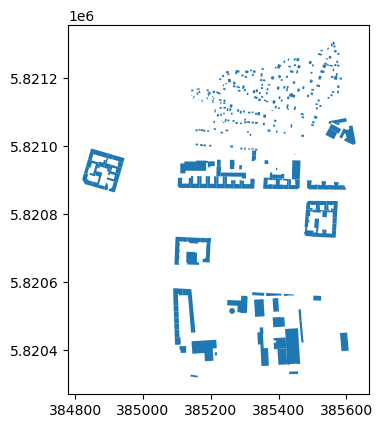

In [28]:
# Visualize building that could not be assigned an archetype
no_archetype = overlap[overlap["ARCHETYPE"].isnull()]["Name"].tolist()
shape_gpd[shape_gpd["Name"].isin(no_archetype)].plot()

In [29]:
# Analzye the building types that could not be assigned an archetype
shape_gpd[shape_gpd["Name"].isin(no_archetype)].category.value_counts()

category
yes            256
apartments      48
residential      5
church           1
Name: count, dtype: int64

<Axes: >

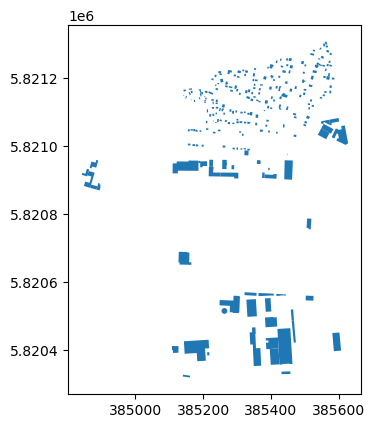

In [30]:
shape_gpd[shape_gpd["Name"].isin(no_archetype) & shape_gpd["category"].isin(["yes"])].plot()


<Axes: >

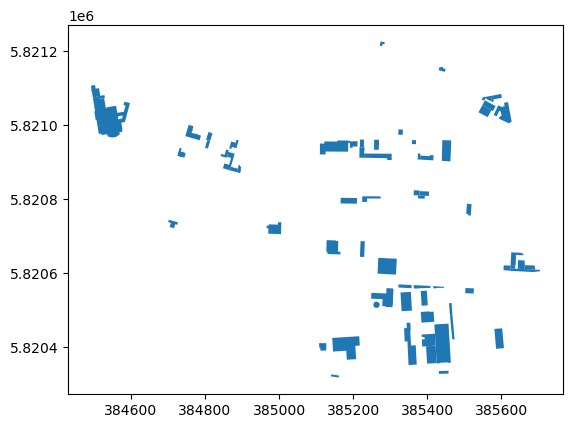

In [31]:
# After visual inspection, yes it it mostly buildings that are related to an type, e.g. the sheds. 
# Get rid of all building smaller than 100m2
shape_gpd["area"] = shape_gpd["geometry"].area
bigger_shape = shape_gpd[shape_gpd["area"] > 100]
bigger_shape[bigger_shape["category"].isin(["yes"])].plot() 

In [32]:
shape_gpd[shape_gpd["area"] > 100 ].category.value_counts()

category
apartments     293
yes             69
residential     51
industrial       8
commercial       6
office           5
school           4
retail           4
public           4
service          2
church           2
house            2
sports_hall      1
warehouse        1
houseboat        1
Name: count, dtype: int64

In [33]:
small_buildings = shape_gpd[shape_gpd['area'] < 100]['Name'].tolist()

In [34]:
# Calibration with Archetypes
# For checking different renovation status
# Random Assesment of year for Non Residential Buildings
renovation_arechteypes= ["" , "NR", "AR"] 
non_residential_variations = ["_A", "_B", "_C"]

In [35]:
# For AB type buildings after 1978 no data is available
# Model them as MF 

def find__enhanced_year_range(bldg_type, year):
    # function determines the year range that a given year falls into based on its categorization  
    if bldg_type in ["yes", "apartments", "residential", "house", "apartment"] and isinstance(year, int):
        #determine bldg age groups on years
        if year == "bis 1900":
            return "1860-1918"
        if 1860 <= year <= 1918:
            return "1860-1918"
        elif 1919 <= year <= 1948:
            return "1919-1948"
        elif 1949 <= year <= 1957:
            return "1949-1957"
        elif 1958 <= year <= 1968:
            return "1958-1968"
        elif 1969 <= year <= 1978:
            return "1969-1978"
        elif 1979 <= year <= 1983:
            return "1979-1983"
        elif 1984 <= year <= 1994:
            return "1984-1994"
        elif 1995 <= year <= 2001:
            return "1995-2001"
        elif 2002 <= year <= 2009:
            return "2002-2009"
        elif 2010 <= year <= 2015:
            return "2010-2015"
        elif 2016 <= year <= 2030:
            return "2016-2030"
        else:
            return None
    else:
        if isinstance(year, int):
            # Non Residential building groups
            if 1860 <= year <= 1978:
                return "1860-1978"
            elif 1979 <= year <= 2009:
                return "1979-2009"
            elif 2010 <= year <= 2030:
                return "2010-2030"
            else:
                return None
        else:
            return None

        
# ADD MFH Archetypes for Apparments constructed after 1978
ENHANCED_ARCHETYPES = {
     "apartments": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
    "residential": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
      "yes": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
    "industrial": {
        "1860-1978": "NWG_G2_A",
        "1979-2009": "NWG_G2_B",
        "2010-2030": "NWG_G2_C",
    }, 

    "office": {
        "1860-1978": "NWG_1_A",
        "1979-2009": "NWG_1_B",
        "2010-2030": "NWG_1_C",
    },
      "commercial": {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "retail" : {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "warehouse": {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
        "service" : {
            "1860-1978": "NWG_10_A",
        "1979-2009": "NWG_10_B",
        "2010-2030": "NWG_10_C",
        },
        "school": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    },
    "public": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }, 
    "house": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },"manufacture" : {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
    
        "kindergarten": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    }, 
    "sports_hall": {
        "1860-1978": "NWG_6_A",
        "1979-2009": "NWG_6_B",
        "2010-2030": "NWG_6_C",
    }
    , 
    "church": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }}



In [36]:
def match_enhanced_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        print(year)
        return None 
    year_range = find__enhanced_year_range(bldg_type, average_year)
    if bldg_type in ENHANCED_ARCHETYPES and year_range in ENHANCED_ARCHETYPES[bldg_type]:
        return ENHANCED_ARCHETYPES[bldg_type][year_range]
    return None


overlap["ENHANCED_ARCHETYPE"] = overlap.apply(lambda row: match_enhanced_building_type(row['category'], row['ueberw_dek']), axis=1)

1901-1910 <class 'str'>
2001-2010 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1981-1990 <class 'str'>
1981-1990 <class 'str'>
1981-1990 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
nan <class 'float'>
nan
1921-1930 <class 'str'>
2001-2010 <class 'str'>
2001-2010 <class 'str'>
nan <class 'float'>
nan
nan <class 'float'>
nan
nan <class 'float'>
nan
1921-1930 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1951-1960 <class 'str'>
1931-1940 <class 'str'>
1931-1940 <class 'str'>
1931-1940 <class 'str'>
1951-1960 <class 'str'>
1901-1910 <class 'str'>
nan <class 'float'>
nan
1901-1910 <class 'str'>
2001-2010 <class 'str'>
2001-2010 <class 'str'>
nan <class 'float'>
nan
1901-1910 <class 'str'>
1901-1910 <class 'str'>
2011-2015 <class 'str'>
2011-2015 <class 'str'>
nan <class 'float'>
nan
nan <class 'float'>
nan
nan <class 'float'>
nan
nan <class 'float'>
nan
nan <class 'float'>
nan
nan <class 'float'>
nan
1951-1960 <class 'str'>
gemischte Baualt

In [37]:
overlap[overlap["ueberw_dek"] == "gemischte Baualtersklasse"][['x_bis_1900', 'x1901_1910', 'x1911_1920', 'x1921_1930', 'x1931_1940', 'x1941_1950', 'x1951_1960', 'x1961_1970', 'x1971_1980', 'x1981_1990', 'x1991_2000', 'x2001_2010', 'x2011_2015']]


,x_bis_1900,x1901_1910,x1911_1920,x1921_1930,x1931_1940,x1941_1950,x1951_1960,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015
41,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
42,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
43,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
44,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
45,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
46,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
47,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
48,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
49,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
50,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [38]:
# Model them all as AB_B, as majortiy of buildings is somewhat in this category
overlap.loc[overlap['ueberw_dek'] == 'gemischte Baualtersklasse', 'ENHANCED_ARCHETYPE'] = 'AB_B'


In [39]:
def get_year(year_range):
    # Convert NaN and float to string or handle them separately
    if pd.isna(year_range):
        return None  # Handle NaN values explicitly
    if not isinstance(year_range, str):
        year_range = str(year_range)  # Convert non-string to string

    # Now the original logic, slightly adjusted for clarity
    if '-' in year_range:
        start_year, end_year = year_range.split('-')
        average_year = (int(start_year) + int(end_year)) // 2
        return average_year
    elif year_range == "gemischte Baualtersklasse":  # Fixed the condition checks
        return 1918
    elif year_range == "bis 1900":
        return 1900
    elif year_range == "NaN":  # This check might be redundant now
        return None

    try:
        return int(year_range)  # Handles cases where the year is not a range but a single year
    except ValueError:
        # Handles any unexpected string that cannot be converted directly to int
        return None

overlap["YEAR"] = overlap.apply(lambda row: get_year(row['ueberw_dek']), axis=1)

In [40]:
# Assign 1ST_USE type 
def match_1st_use_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        print(year)
        return None 
    year_range = find__enhanced_year_range(bldg_type, average_year)
    if bldg_type in ENHANCED_ARCHETYPES and year_range in ENHANCED_ARCHETYPES[bldg_type]:
        return ENHANCED_ARCHETYPES[bldg_type][year_range]
    return None

In [41]:
overlap["ARCHETYPE"].value_counts().index
# Assumptions
# For all residential building types, the MULTI_RES is assigned
# For office (NWG1), OFFICE is assigned
# For University (NWG2), UNIVERSITY is assigned
# For IWU Health and care buildings (NWG3), HEALTH is assigned
# For School (NWG4), SCHOOL is assigned
# # For culture, MUSEUM is assigned
# For all industrial buildings, INDUSTRIAL is assigned
# For IWU Technial buildings, TECHNICAL is assigned
USE_DICT = {
    'MFH_J': "MULTI_RES",
    'AB_B': "MULTI_RES",
    'AB_D': "MULTI_RES",
    'MFH_K': "MULTI_RES",
    'AB_C': "MULTI_RES",
    'NWG_5_A': "MUSEUM",
    'NWG_G2_C': "UNIVERSITY",
    'MFH_H': "MULTI_RES",
    'NWG_G1_B': "OFFICE",
    'NWG_G1_C': "OFFICE",
    'NWG_4_A': "SCHOOL",
    'NWG_G1_A': "OFFICE",
    'NWG_G2_A': "INDUSTRIAL",
    'NWG_1_B': "OFFICE",
    'NWG_8_B': "MULTI_RES",
    'NWG_1_A': "MULTI_RES",
    'NWG_10_B': "MULTI_RES",
    'NWG_6_A': "MULTI_RES",
    'NWG_1_C': "OFFICE",
    'NWG_10_A': "INDUSTRIAL",
    'NWG_10_C': "MULTI_RES"
}
overlap["1ST_USE"] = overlap["ENHANCED_ARCHETYPE"].map(USE_DICT)

In [42]:
buildings_assigned_standard = overlap[overlap["1ST_USE"].notnull()]["Name"].tolist()

In [43]:
overlap

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area,ARCHETYPE,ENHANCED_ARCHETYPE,YEAR,1ST_USE
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853,NWG_4_A,NWG_4_A,1905.0,SCHOOL
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059,NWG_10_B,NWG_10_B,2005.0,MULTI_RES
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172,AB_D,AB_D,1955.0,MULTI_RES
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086,AB_D,AB_D,1955.0,MULTI_RES
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618,None,MFH_H,1985.0,MULTI_RES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,B1786,1.0,1,3.0,1,NaN,yes,OSM - as it is,17-20,Tegeler Weg,...,NaN,NaN,214.0,41.0,Sicherheit und Ordnung,6358.958904,AB_C,AB_C,1925.0,MULTI_RES
785,B1787,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,744.0,2.0,"Geschlossene Blockbebauung, Hinterhof (1870er-...",1949.023162,AB_C,AB_C,1925.0,MULTI_RES
786,B1788,6.0,6,3.0,1,NaN,apartments,OSM - as it is,21,Mierendorffstraße,...,NaN,NaN,675.0,1.0,"Dichte Blockbebauung, geschlossener Hinterhof ...",764.306084,AB_B,AB_B,1905.0,MULTI_RES
787,B1789,6.0,6,3.0,1,NaN,apartments,OSM - as it is,23,Mierendorffstraße,...,NaN,NaN,675.0,1.0,"Dichte Blockbebauung, geschlossener Hinterhof ...",696.337439,AB_B,AB_B,1905.0,MULTI_RES


In [44]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    config.project = os.path.join(project_folder, 'Baseline')
    config.scenario_name = f'{year}'
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
    except WindowsError:
        pass 

In [45]:
overlap_copy = overlap.copy()

# Ensure no duplicate 'Name' values in overlap
overlap_copy = overlap_copy.drop_duplicates(subset='Name')

# Create a dictionary from overlap for fast lookup
overlap_dict = overlap_copy.set_index('Name').to_dict(orient='index')


# Custom function to update the STANDARD, 1ST_USE and YEAR columns
def update_columns(row):
    if row['Name'] in overlap_dict:
        arch = overlap_dict[row['Name']]['ARCHETYPE']
        enh_arch = overlap_dict[row['Name']]['ENHANCED_ARCHETYPE']
        first_use = overlap_dict[row['Name']]['1ST_USE']
        year = overlap_dict[row['Name']]['YEAR']
        
        standard = arch if pd.notna(arch) else enh_arch
        return pd.Series([standard, first_use])
    return pd.Series([row['STANDARD'], row['1ST_USE'], row["YEAR"]])


In [46]:
# Reset Index of overlap for mapping 
overlap["ARCHETYPE"] = np.where(overlap["ARCHETYPE"].isnull(), overlap["ENHANCED_ARCHETYPE"], overlap["ARCHETYPE"])
archetype_map = overlap.set_index('Name')['ARCHETYPE']
year_map = overlap.set_index('Name')['YEAR']
first_use_map = overlap.set_index('Name')['1ST_USE']

In [47]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 

    config.project = os.path.join(project_folder, 'Benchmark')
    config.scenario_name = f'{year}'
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}')

    
    archetype_path = os.path.join(path_to_new_scenario, "inputs", "building-properties", "typology.dbf")
    archetype_file = gpd.read_file(archetype_path)

    archetype_file [['STANDARD', '1ST_USE', "YEAR"]] = archetype_file.apply(update_columns, axis=1)

    no_archetype_buildings = archetype_file[archetype_file["STANDARD"].isnull()]["Name"].tolist() + archetype_file[archetype_file["1ST_USE"].isnull()]["Name"].tolist()


    archetype_buildings = [x for x in list(archetype_file["Name"]) if x not in no_archetype_buildings]
    archetype_file = archetype_file[archetype_file['Name'].isin(archetype_buildings)]
    archetype_file.to_file(archetype_path)
    zone_path = os.path.join(path_to_new_scenario, "inputs", "building-geometry", "zone.shp")
    zone_gdf = gpd.read_file(zone_path)
    #zone_gdf.drop(zone_gdf[zone_gdf['Name'].isin(no_archetype_buildings)], inplace=True)
    zone_gdf = zone_gdf[zone_gdf['Name'].isin(archetype_buildings)]
    zone_gdf.to_file(zone_path)
    
    archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=archetype_buildings)
    config.schedule_maker.buildings = archetype_buildings 
    schedule_maker(config)
    #config.radiation.buildings = list_assigned_standard
    config.radiation.buildings = archetype_buildings
    radiation_main(config)   
    #config.demand.buildings = list_assigned_standard
    config.demand.overheating_warning = False
    demand_main(config) 



Running occupancy model for scenario c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\Benchmark\2020
Running occupancy model  with schedule model=deterministic
Using 47 CPU's
Schedule for building No. 1 completed out of 675: B1054
Schedule for building No. 2 completed out of 675: B1046
Schedule for building No. 3 completed out of 675: B1032
Schedule for building No. 4 completed out of 675: B1070
Schedule for building No. 5 completed out of 675: B1050
Schedule for building No. 6 completed out of 675: B1020
Schedule for building No. 7 completed out of 675: B1074
Schedule for building No. 8 completed out of 675: B1000
Schedule for building No. 9 completed out of 675: B1024
Schedule for building No. 10 completed out of 675: B1062
Schedule for building No. 11 completed out of 675: B1066
Schedule for building No. 12 completed out of 675: B1008
Schedule for building No. 13 completed out of 675: B1058
Schedule for building No. 14 completed out of 675: B1042
Schedule for building No. 1

<Axes: >

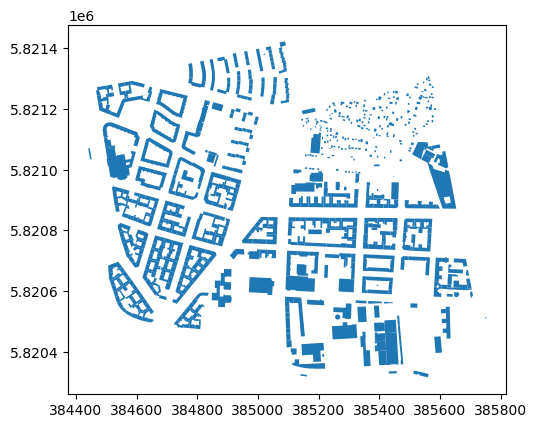

In [48]:
# Based on these findings, try to find a model that fits the data
# However, there is unvertainty in the data in the Renovation status of the buildings 
# Calibratin the year and renovation status is compute demanding task. 
# Troy to reduce the buildings as much as possible

# Shapes considered 
path_to__benchmark_shapes = os.path.join(project_folder, 'Benchmark', '2020', "inputs", "building-geometry", "zone.shp")	
benchmark_shapes_gdf = gpd.read_file(path_to__benchmark_shapes)
benchmark_shapes_gdf.plot()

In [49]:
# There is a lack of builidngs and buildings below <100 sqm are still present
# Remove buildings below 100 sqm
# Validate the type and archetype for other buildings 
no_archetype = overlap[overlap["ENHANCED_ARCHETYPE"].isnull()].Name.tolist()

<Axes: >

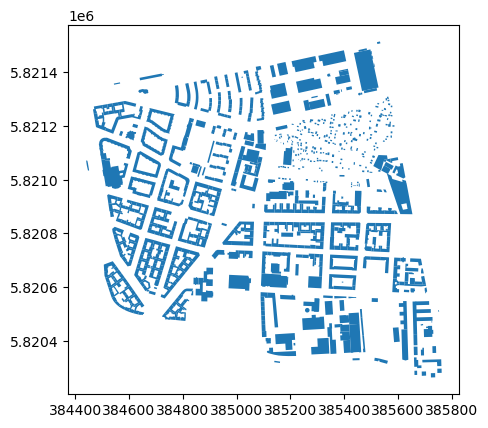

In [50]:
# Get original shape file
path_to__baseline_shapes = os.path.join(project_folder, "Baseline", "2020", "inputs", "building-geometry", "zone.shp")
baseline_shapes_gdf = gpd.read_file(path_to__baseline_shapes)
baseline_shapes_gdf.plot()

<Axes: >

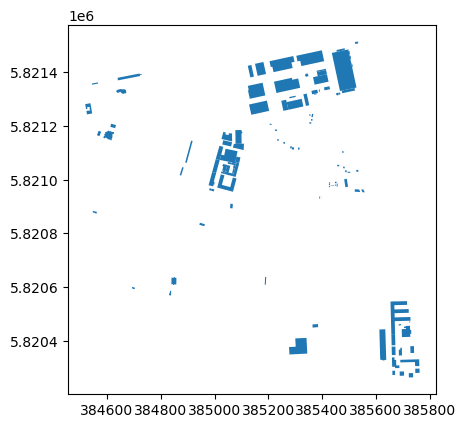

In [51]:
baseline_shapes_gdf[baseline_shapes_gdf["Name"].isin(no_archetype)].plot()

In [52]:
# Calibration
# Stop running schedule 
# Rerund radiation and archetypes
# Drop all data that is not needed

In [53]:
ARCHETYPES = {
    "No_Refurbishment" : "",
    "Normal_Refurbishment" : "_NR",
    "Advanced_Refurbishment" : "_AR"
}

# Write a function, that generates archetypes based on the building type and year

def create_renovation_status(refurbishment, bldg_type):
    # This function matches building use to its archetype based on year
    temp_standard = bldg_type.split("_")[0]
    if bldg_type.split("_")[-1] in ["NR", "AR"]:
        return bldg_type
    if temp_standard in ["SFH", "AB", "MFH", "HR", "TH"]:
        return bldg_type + ARCHETYPES[refurbishment]
    else:
        return bldg_type




In [57]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for archetype in ARCHETYPES.keys():
    if archetype == "No_Refurbishment":
        continue
    

    for year in years: 
        config.project = os.path.join(project_folder, f'Benchmark_{archetype}')
        # create the destination path for copying the baseline scenario
        path_to_benchmark = os.path.join(project_folder, 'Benchmark', f'{year}') 
        path_to_new_scenario = os.path.join(project_folder, f'Benchmark_{archetype}', f'{year}')
        config.scenario_name = f'{year}'
        try:
            shutil.copytree(path_to_benchmark, path_to_new_scenario)
        except WindowsError:
            pass 


for archetype in ARCHETYPES.keys():
    if archetype == "No_Refurbishment":
        continue
    for year in years:
        config.project = os.path.join(project_folder, f'Benchmark_{archetype}')
        config.scenario_name = f'{year}'
        path_to_new_scenario = os.path.join(project_folder, f'Benchmark_{archetype}', f'{year}')
        archetype_path = os.path.join(path_to_new_scenario, "inputs", "building-properties", "typology.dbf")
        archetype_file = gpd.read_file(archetype_path)

        archetype_file["STANDARD"] = archetype_file["STANDARD"].apply(lambda x: create_renovation_status(archetype, x))
        archetype_file.to_file(archetype_path)

        no_archetype_buildings = archetype_file[archetype_file["STANDARD"].isnull()]["Name"].tolist() + archetype_file[archetype_file["1ST_USE"].isnull()]["Name"].tolist()
         
        archetype_buildings = [x for x in list(archetype_file["Name"]) if x not in no_archetype_buildings]
    
    
        archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=archetype_buildings)
        archetypes_mapper_main(config)
        config.schedule_maker.buildings = archetype_buildings
        config.radiation.buildings = archetype_buildings
        config.radiation.consider_intersections = True
        config.schedule_maker.buildings = archetype_buildings 
        schedule_maker(config)
        radiation_main(config)   
        config.demand.buildings = archetype_buildings
        config.demand.overheating_warning = False
        demand_main(config) 
        

Running archetypes-mapper with scenario = c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\Benchmark_Normal_Refurbishment\2020
Running occupancy model for scenario c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\Benchmark_Normal_Refurbishment\2020
Running occupancy model  with schedule model=deterministic
Using 47 CPU's
Schedule for building No. 1 completed out of 675: B1118
Schedule for building No. 2 completed out of 675: B1186
Schedule for building No. 3 completed out of 675: B1078
Schedule for building No. 4 completed out of 675: B1086
Schedule for building No. 5 completed out of 675: B1166
Schedule for building No. 6 completed out of 675: B1094
Schedule for building No. 7 completed out of 675: B1138
Schedule for building No. 8 completed out of 675: B1178
Schedule for building No. 9 completed out of 675: B1190
Schedule for building No. 10 completed out of 675: B1130
Schedule for building No. 11 completed out of 675: B1158
Schedule for building No. 12 completed ou

In [58]:
archetype_file

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,NWG_4_A,NaN,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,NWG_10_B,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,AB_D_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,AB_D_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,MFH_H_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
670,B1786,AB_C_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
671,B1787,AB_C_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
672,B1788,AB_B_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
673,B1789,AB_B_AR,NaN,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [59]:
config.project

'c:\\Users\\felix\\Programmieren\\Mierendorff_CEA\\CEA_model337\\Benchmark_Advanced_Refurbishment'

In [60]:
# Test new german database

import cea.config
from cea.datamanagement import data_initializer  
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years:
    path_to_new_scenario = os.path.join(project_folder, 'Updated_DE_Database', f'{year}') # create the destination path for copying the baseline scenario
    path_to_benchmark= os.path.join(project_folder, 'Benchmark', year)
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
    except WindowsError:
        pass 
    config.project = os.path.join(project_folder, 'Updated_DE_Database')
    config.scenario_name = f'{year}'
    path_to_new_scenario = os.path.join(project_folder, 'Updated_DE_Database', f'{year}')
    config.general.database_path = "DE_updated"
    config.save()
    #config.data_initializer(locator=cea.inputlocator.InputLocator(config.scenario), databases_path=r"C:\Users\felix\Documents\CityEnergyAnalyst\CityEnergyAnalyst\cea\databases\DE_updated")


In [61]:
import cea.config
from cea.datamanagement import data_initializer  
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years:
        path_to_new_scenario = os.path.join(project_folder, 'Updated_DE_Database', f'{year}')
        config.project = os.path.join(project_folder, 'Updated_DE_Database')
        config.scenario_name = f'{year}'

        archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                        update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                        update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                        update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                        buildings=archetype_buildings)
        config.schedule_maker.buildings = archetype_buildings 
        schedule_maker(config)
        config.radiation.buildings = archetype_buildings
        radiation_main(config)   
        config.demand.buildings = archetype_buildings
        config.demand.overheating_warning = False
        demand_main(config) 


Running occupancy model for scenario c:\Users\felix\Programmieren\Mierendorff_CEA\CEA_model337\Updated_DE_Database\2020
Running occupancy model  with schedule model=deterministic
Using 47 CPU's
Schedule for building No. 1 completed out of 675: B1016
Schedule for building No. 2 completed out of 675: B1032
Schedule for building No. 3 completed out of 675: B1024
Schedule for building No. 4 completed out of 675: B1046
Schedule for building No. 5 completed out of 675: B1062
Schedule for building No. 6 completed out of 675: B1042
Schedule for building No. 7 completed out of 675: B1000
Schedule for building No. 8 completed out of 675: B1004
Schedule for building No. 9 completed out of 675: B1066
Schedule for building No. 10 completed out of 675: B1020
Schedule for building No. 11 completed out of 675: B1054
Schedule for building No. 12 completed out of 675: B1074
Schedule for building No. 13 completed out of 675: B1078
Schedule for building No. 14 completed out of 675: B1070
Schedule for buil